In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections
from glob import glob
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow


from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from sklearn.model_selection import *

from tqdm import *

import astrohack
from astrohack import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

Using TensorFlow backend.


In [2]:
# TODO, improvement ideas

# TPOT python auto ml
# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:

def img_preprocnoread(Xg, preProcNum = 0):
    if preProcNum & 128: #hackaton preproc
        Xg = cleanupImage(Xg)

    if preProcNum & 1: # vflip
        Xg = np.flip(Xg,0)
    if preProcNum & 2: # hflip
        Xg = np.flip(Xg,1)
    if preProcNum & 4: # rotate
        Xg = np.rot90(Xg)
    if preProcNum & 64: # crop
        Xg = crop_image(Xg)


    # log, normalize, scale (new)
    # scale, log, normalize (old)
    
    if preProcNum & 8: # scale [0,1]
        Xg = scale_image(Xg)
    if preProcNum & 16: # log
        Xg = np.log1p(Xg - Xg.min())
    if preProcNum & 32: # normalize
        Xg = normalize_image(Xg)

    
    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr

## data folder set up and test

In [4]:
astrohack.dataFolder = 'data/mainData_original/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

# ML part

In [6]:
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')


### Read metadata file

In [7]:
df =  getAstrohackDataFrame()
df.head()


,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,ML_g_rel_err,ML_i_rel_err,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
174,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,2.472975,2.279201,0.105385,0.10490392881262686,10.325,0.045,326.142854,2.113489e+10,2.189920e+09,True
216,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.841365,1.148099,0.093758,0.09498951605786418,9.824,0.040,293.571417,6.668068e+09,6.141517e+08,True
237,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.703785,1.051369,0.122754,0.12327084107474802,9.923,0.053,167.142861,8.375293e+09,1.022096e+09,True
276,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.248502,1.269311,0.183377,0.1837691489095808,10.356,0.079,282.000016,2.269865e+10,4.128980e+09,True
332,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.999996,0.378155,0.419816,0.559744,0.219920,0.2194701990290622,9.234,0.094,194.999996,1.713957e+09,3.709741e+08,True


### Filter images that have no known mass, no actual image, or with an unknown error

In [8]:
print(len(df.SDSS_ID.values))

76908


In [9]:
vgg16 = None
r50 = None
cnn = None

In [10]:

runNameParams.append('ReadLog1pNormCrop.75origOldCleanup')

postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']
distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]
numFeatures = 0

def getFeatures(preProcessingNum):
    global vgg16, r50, cnn,numFeatures
    
    if vgg16 == None:
        vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
    if r50 == None:
        r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
#     if cnn == None:
#         cnn = load_model('encoder.h5')
    Xg3r50 = []
    Xg3vgg16 = []
    postImgFeatures = []
    csize=2
    preImgFeatures = []
    cnnFeatures = []

    maxChunkNumber = math.ceil(len(ids)/chunkSize)
    chunkStart = 0
    # for chunkStart in tqdm(range(0, 3)):
    
    # do the loading by chunk to avoid consuming too much memory
    for chunkStart in tqdm(range(0, len(ids), chunkSize)):
        curChunk = int((chunkStart//chunkSize))
        valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

        Xg_ = []
        pre_ex_ = []

        # preprocess the image and collect some raw image stats
        for i in range(chunkStart, chunkStart+valuesInThisChunk):
            X = read_image(ids[i])
            Xg_.append(img_preprocnoread(X, preProcessingNum))
            pre_ex_.append([
                X.sum(),
                X.min(),
                X.max(),
                X.mean(),
                X.std(),
                X[X.shape[0]//2,X.shape[1]//2],
                np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
                X.shape[0], 
            ])

        # stack the postprocessing
        pre_ex = np.stack(pre_ex_)
        Xg = np.stack(Xg_)

        # collect some post processing stats
        post_ex = np.hstack([
            np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
            np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
            ])

        
#         cnnFeatures_ = cnn.predict( Xg[:,:,:,newaxis])
#         cnnFeatures_ = cnnFeatures.reshape(valuesInThisChunk, -1)
        
        # prepare correct dimension to feed to imagenet networks
        Xg3 = np.zeros((valuesInThisChunk,224,224,3))
        Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)

        # do r50 prediction
        Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
        Xg3vgg16_ = vgg16.predict(Xg3)
        


        if chunkStart == 0:
            Xg3r50 = Xg3r50_
            Xg3vgg16 = Xg3vgg16_
            preImgFeatures = pre_ex
            postImgFeatures = post_ex
#             cnnFeatures = cnnFeatures_
        else:
            Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
            Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
            preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
            postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)
#             cnnFeatures = np.concatenate([cnnFeatures, cnnFeatures_], axis = 0)


    # add features from the data itself (distance)
    Distance = df.Distance.values[:N].reshape(N,1)

    Xg3f = np.hstack ( ( 
            Xg3r50, 
            Xg3vgg16, 
#             cnnFeatures,
            Distance,
            1/Distance,
            Distance**2,
            1/(Distance**2),
            Distance**3,
            1/(Distance**3),
            np.log(Distance),
            1/np.log(Distance),
            np.log(Distance**2),
            1/np.log(Distance**2),
            np.log(Distance)**2,
            1/np.log(Distance)**2,
            preImgFeatures,
            postImgFeatures
            ) )


    Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
                + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
#                 + [prefixThisRound+'.cnn.' + str(i) for i in range(cnnFeatures.shape[1])] 
                + [prefixThisRound+'.'+ n for n in distanceNames]
                + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
                + [prefixThisRound+'.'+ n for n in postImgFeatureNames])
    return Xg3f, Xg3fNames

# numFeatures = 2048 + 1000 + 7*7 *8 + len(postImgFeatureNames) + len(preImgFeatureNames) + len(distanceNames) 
numFeatures = 2048 + 1000 + len(postImgFeatureNames) + len(preImgFeatureNames) + len(distanceNames) 

    

In [11]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [12]:
def lgb_chi2(Yp, train_data):
    Y = train_data.get_label()
    err = 1/train_data.get_weight()**0.5
    return 'Chi²', round(xi2(Y,Yp,err),1), False


In [13]:
def getLGBMModelsWithCV(trainSet, YSet, errSet, errlinSet):
    kf = KFold(n_splits=nSplits,shuffle=True, random_state=220477)

    cvtrainpreds = np.zeros([len(trainSet),nSplits])
    models = []
    counter = 0
    for tix, vix in kf.split(trainSet):
        X_train, X_test = trainSet[tix], trainSet[vix]
        Y_train, Y_test = YSet[tix], YSet[vix]

        lgb_train = lgbm.Dataset(X_train, Y_train)
        lgb_eval = lgbm.Dataset(X_test, Y_test)

        lgb_train.set_weight(1/errSet[tix]**2)
        lgb_eval.set_weight(1/errSet[vix]**2)
        
        gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=maxBoostRuns,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100,
                        feval = lgb_chi2
                        )
        models.append(gbm)

        p = gbm.predict(X_test)

        cvtrainpreds[vix,counter] = p
        counter = counter+1
        
    return models, cvtrainpreds

# models, cvtrainpreds, xis, linxis = getModels(Xg3f[:M], Y[:M])

# print(models, cvtrainpreds)

# print(xis, linxis)


In [14]:
def getLGBMModelsNoCV(trainSet, YSet, errSet, errlinSet):
    cvtrainpreds = np.zeros([len(trainSet),1])
    models = []
    counter = 0

    tix, vix = list(range(0,int(len(trainSet)*0.9))), list(range(int(len(trainSet)*0.9),len(trainSet)))
    
    X_train, X_test = trainSet[tix], trainSet[vix]
    Y_train, Y_test = YSet[tix], YSet[vix]

    lgb_train = lgbm.Dataset(X_train, Y_train)
    lgb_eval = lgbm.Dataset(X_test, Y_test)

    lgb_train.set_weight(1/errSet[tix]**2)
    lgb_eval.set_weight(1/errSet[vix]**2)

    gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=maxBoostRuns,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100,
                        feval = lgb_chi2
                     
                    )
    models.append(gbm)

    p = gbm.predict(X_test)
    cvtrainpreds[vix,counter] = p
    counter = counter+1
        
    return models, cvtrainpreds


In [15]:
TRAIN = 0
TEST = 4

FEATURES = 0
TRUTH = 1
ERROR = 2
LINERROR = 3

ID = 8
FEATURENAMES = 9

data = list(range(10))


In [16]:
# breakqsdqsd

# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [17]:
df = df.sample(frac=1).reset_index()

In [18]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)

prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

prefixThisRound = prefixThisRound + '-model11'
    
chunkSize = 200
# nSplits = 3
reloadImagesAndPreprocess = 1
numPreprocessing = 1
nSplits = 1

maxBoostRuns = 30000 # 30000
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout
# N = int(N*0.1)
# M = int(M*0.1)


# N = int(N*0.01)
# M = int(M*0.01)


In [19]:
df.columns

Index(['index', 'SDSS_ID', 'RA', 'DEC', 'D25', 'redshi', 'GalSize_kpc',
       'D_Mpc', 'd_pix_kpc', 'ML_g', 'ML_i', 'ML_g_rel_err', 'ML_i_rel_err',
       'logMstar', 'err_logMstar', 'Distance', 'lin_mass', 'lin_err',
       'hasFile'],
      dtype='object')

In [20]:
# plt.figure(figsize=(18,8))
# plt.subplot(121)
# plt.xlabel('ML_g')
# plt.ylabel('log(M)')
# sns.kdeplot(x=df.ML_g, y=df.logMstar, alpha=0.2)
# plt.subplot(122)
# plt.hist(x=df.ML_g, bins=100)
# plt.title('ML_g histogram')
# plt.xlabel('ML_g')
# 1

In [21]:
ids = df.SDSS_ID.values[:N]
#Y = df.logMstar.values[:N]
Y = df.ML_g.values[:N]
err = df.ML_g_rel_err.values[:N] * Y
# Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [22]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

76908
69217
200
sp-newSource-ReadLog1pNormCrop.75origOldCleanup-model11


In [23]:
ttaPredictions = np.zeros([numPreprocessing,nSplits,N-M])


data[TRAIN+FEATURES] = np.ones([0,numFeatures])
data[TRAIN+TRUTH] = np.ones([0])
data[TRAIN+ERROR] = np.ones([0])
data[TRAIN+LINERROR] = np.ones([0])
data[TEST+FEATURES] = np.ones([0,numFeatures])
data[TEST+TRUTH] = np.ones([0])
data[TEST+ERROR] = np.ones([0])
data[TEST+LINERROR] = np.ones([0])


data[ID] = ids


curPreproc = PP_LOG1P+PP_NORMALIZE+PP_CROP+PP_HACKATON+PP_SCALE
fileName = prefixThisRound + '-' + str(N) + 'allFeatures' + str(curPreproc) + '.npy'
if reloadImagesAndPreprocess == 1 or not(os.path.isfile(fileName)):
    for curTTA in range(numPreprocessing):
        a, Xg3fNames = getFeatures(curTTA+curPreproc)

        data[TRAIN+FEATURES] = np.vstack([data[TRAIN+FEATURES],a[:M]])
        data[TRAIN+TRUTH] = np.hstack([data[TRAIN+TRUTH],Y[:M]])
        data[TRAIN+ERROR] = np.hstack([data[TRAIN+ERROR],err[:M]])
        data[TRAIN+LINERROR] = np.hstack([data[TRAIN+LINERROR], err_lin[:M]])

        data[TEST+FEATURES] = np.vstack([data[TEST+FEATURES],a[M:]])
        data[TEST+TRUTH] = np.hstack([data[TEST+TRUTH],Y[M:]])
        data[TEST+ERROR] = np.hstack([data[TEST+ERROR],err[M:]])
        data[TEST+LINERROR]  = np.hstack([data[TEST+LINERROR] , err_lin[M:]])

    np.save(fileName, data)
else:
    data = np.load(fileName)


print("loaded")

100%|██████████| 385/385 [2:28:55<00:00, 20.52s/it]  


loaded


In [24]:
# data.append(Xg3fNames)
# print(len(data))
# np.save(fileName, data)

In [25]:
from keras.models import load_model

In [26]:
models, cvtrainpreds = getLGBMModelsNoCV(data[TRAIN+FEATURES], data[TRAIN+TRUTH], data[TRAIN+ERROR], data[TRAIN+LINERROR])

ppreds = np.zeros([len(models),data[TEST+FEATURES].shape[0]])
for i, m in zip(range(len(models)),models):
    mp = m.predict(data[TEST+FEATURES])
    ppreds[i] = mp

cvpred = ppreds.mean(axis=0)
mpred = ppreds.reshape((numPreprocessing,-1)).mean(axis=0)
print("Iteration : {}".format(numPreprocessing))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.863532	training's Chi²: 87.1	valid_1's rmse: 0.861799	valid_1's Chi²: 74.5
[200]	training's rmse: 0.617649	training's Chi²: 44.6	valid_1's rmse: 0.682452	valid_1's Chi²: 46.7
[300]	training's rmse: 0.553837	training's Chi²: 35.8	valid_1's rmse: 0.639889	valid_1's Chi²: 41.1
[400]	training's rmse: 0.528825	training's Chi²: 32.7	valid_1's rmse: 0.624551	valid_1's Chi²: 39.1
[500]	training's rmse: 0.514279	training's Chi²: 30.9	valid_1's rmse: 0.616808	valid_1's Chi²: 38.2
[600]	training's rmse: 0.503847	training's Chi²: 29.7	valid_1's rmse: 0.612878	valid_1's Chi²: 37.7
[700]	training's rmse: 0.495384	training's Chi²: 28.7	valid_1's rmse: 0.609992	valid_1's Chi²: 37.3
[800]	training's rmse: 0.488212	training's Chi²: 27.9	valid_1's rmse: 0.608221	valid_1's Chi²: 37.1
[900]	training's rmse: 0.481753	training's Chi²: 27.1	valid_1's rmse: 0.606292	valid_1's Chi²: 36.9
[1000]	training's rmse: 0.476016	trai

In [27]:
# print(M)
# print(trainXg3fStacked.shape)
# testXg3fStacked.shape
# ttaPredictions.shape
# ppreds.shape



Iteration : 1


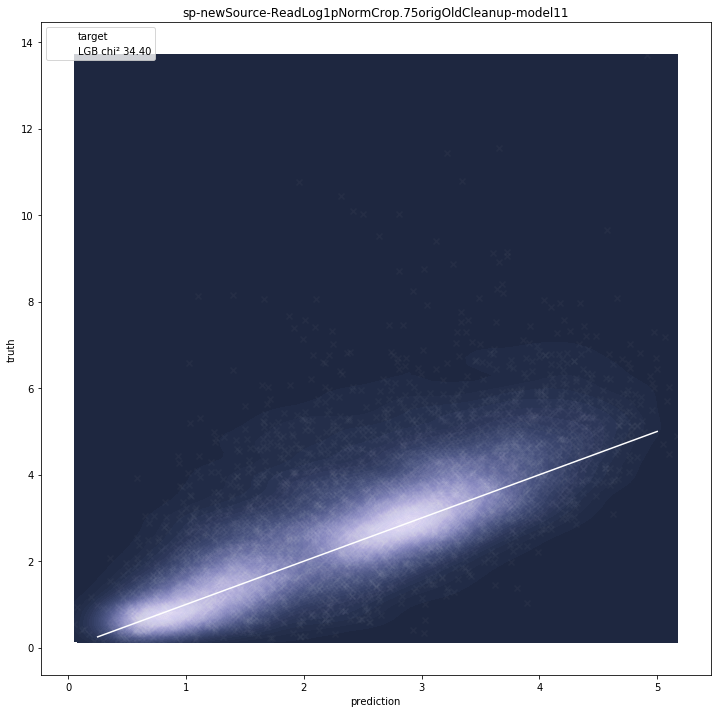

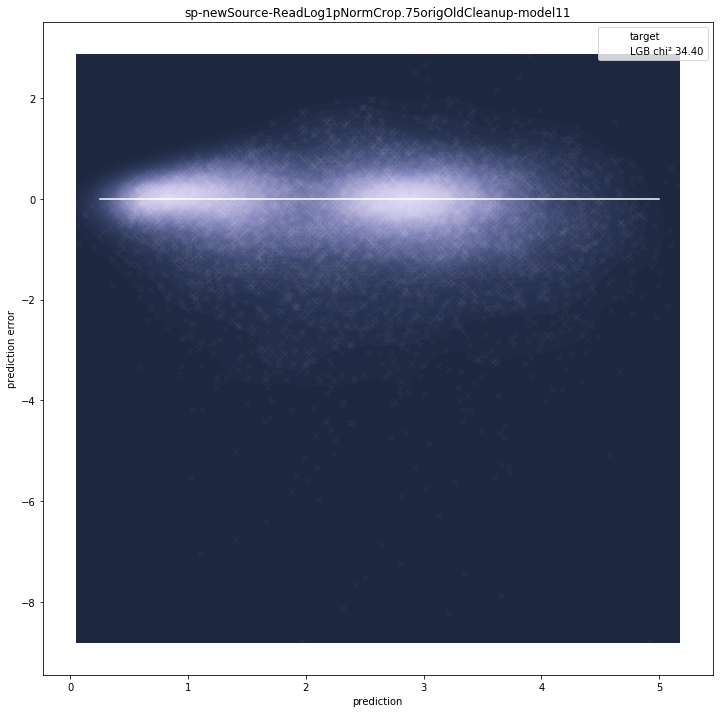

In [28]:

mpred = ppreds.reshape((numPreprocessing,-1)).mean(axis=0)
print("Iteration : {}".format(numPreprocessing))

# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

linChiSq = xi2(mpred, data[TEST+TRUTH], data[TEST+ERROR])

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()
plt.show()

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, mpred-data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0,0], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('prediction error')

plt.legend()
plt.show()

In [29]:
&é"&éazeaze"

SyntaxError: invalid syntax (<ipython-input-29-2105495a1123>, line 1)

In [ ]:
import keras


In [ ]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    epochsPerDraw = 10
    referencePrediction = None
    
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.test_losses = [] # external validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        self.lasttrainplot = None
        self.lasttestplot = None
        
    def on_train_begin(self, logs={}):
        self.initVars()
        self.referenceLoss = xi2(self.referencePrediction, data[TEST+TRUTH], data[TEST+ERROR])

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        currentLearningRate = K.get_value(model.optimizer.lr)
        self.lr.append(currentLearningRate)

        if ( self.i %self.epochsPerDraw != 0 ):
            return

        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.suptitle("{}/{} {} {}".format(self.i, numEpochs, curloss, prefixThisRound))
        
#         ax = plt.subplot(131) # self values
#         if self.lasttrainplot == None or self.i %self.epochsPerDraw == 0:
#             self.plotSelfTrain(ax)
#         else:
#             ax = self.lasttrainplot

        ax = plt.subplot(121)
        if self.lasttestplot == None or self.i %self.epochsPerDraw == 0:
            self.plotSelfTest(ax)
        else:
            ax = self.lasttestplot
    
        ax = plt.subplot(122)
        self.plotLosses(ax)
        

        plt.savefig("pltsave/" + prefixThisRound + "%05d.png" % self.i)
        plt.show();
    
    def plotSelfTrain(self, ax):

        pred = model.predict(data[TRAIN+FEATURES])[:,0]
#         r = rmse(pred,data[TRAIN+TRUTH])
        r = xi2(pred,data[TRAIN+TRUTH], data[TRAIN+ERROR])
        plt.scatter(x=data[TRAIN+TRUTH], y=pred, c='k', alpha=.1, label="NN train {:.2f}".format(r))
#         sns.kdeplot(data[TRAIN+TRUTH], pred,n_levels=10, shade=True, shade_lowest=False, cmap='rainbow', alpha=0.7)
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
#         plt.plot([7, 13], [0,0], 'k-', lw=2, label="target")
#         axes = plt.gca()
#         axes.set_xlim([7,13])
        plt.legend()
        self.lasttrainplot = ax
    
    def plotSelfTest(self, ax):
        
        # lgbm values
        plt.scatter(x=data[TEST+TRUTH], 
                    y=self.referencePrediction, 
                    c='b', alpha=.1, label="ref {:02f}".format(self.referenceLoss))
        
        # test values
        pred = model.predict(data[TEST+FEATURES])[:,0]
        r = xi2(pred,data[TEST+TRUTH], data[TEST+ERROR])
        plt.scatter(x=data[TEST+TRUTH], y=pred, c='g', alpha=.1, label="NN test {:.2f}".format(r))
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
        plt.plot([0, 12], [0, 12], 'k-', lw=2, label="target")
#         axes = plt.gca()
#         axes.set_xlim([7,13])
        plt.legend()
        self.lasttestplot = ax

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="val loss")
        ax.set_yscale("log", nonposy='clip')
        ax.axhline(self.referenceLoss,linestyle='--')
        plt.legend()
        ax2 = ax.twinx()
        ax2.set_yscale('log')
        plt.plot(self.x,self.lr, c='r', label='learning rate', alpha=0.8)
        
#         plt.plot(self.x, self.testrmse, label="test rmse", c='g')
        plt.legend()

        
plot_losses = PlotLosses()

In [ ]:
import models


In [ ]:
print(data[TRAIN+FEATURES].shape)
print(data[TRAIN+TRUTH].shape)

In [ ]:
print(set(np.argwhere(np.isnan(data[TRAIN+FEATURES]))[:,1]))
print(set(np.argwhere(np.isnan(data[TEST+FEATURES]))[:,1]))

In [ ]:
# test keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.optimizers import *

model = Sequential()

model.add(Dense(500, input_shape=(data[TRAIN+FEATURES].shape[1],), activation = 'relu', kernel_initializer='truncated_normal',))
# model.add(Dropout(0.5))

model.add(Dense(300, activation='relu',kernel_initializer='truncated_normal',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu',kernel_initializer='truncated_normal',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='elu',kernel_initializer='truncated_normal'))

model.compile(optimizer='nadam', loss='mse')


reduceLRcallback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=500, verbose=0, mode='auto', epsilon=0.0001, cooldown=20, min_lr=1e-8)

numEpochs = 30000
plot_losses.epochsPerDraw = 20
plot_losses.referencePrediction = mpred
# num = 5000
num = N

model.fit(data[TRAIN+FEATURES][:num,:], 
          data[TRAIN+TRUTH][:num], 
          sample_weight=1/(data[TRAIN+ERROR][:num])**2,
          batch_size=1000, 
          epochs=numEpochs, 
          validation_split = 0.1, 
          verbose = 1,
          callbacks=[plot_losses,reduceLRcallback])

In [ ]:
currentLearningRate = K.get_value(model.optimizer.lr)
print(currentLearningRate)
# K.set_value(model.optimizer.lr, currentLearningRate*.8)

In [ ]:
reduceLRcallback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=100, verbose=0, mode='auto', epsilon=0.0001, cooldown=20, min_lr=0)
continueTraining=0

In [ ]:
# continueTraining = 1

# add extra big ones
# indexes = np.where(data[TRAIN+TRUTH] > 5)[0]
# data[TRAIN+TRUTH] = np.hstack([data[TRAIN+TRUTH],data[TRAIN+TRUTH][indexes]])
# data[TRAIN+FEATURES] = np.vstack([data[TRAIN+FEATURES],data[TRAIN+FEATURES][indexes]])

In [ ]:
if continueTraining == 1:
    plot_losses.referencePrediction = mpred
    numEpochs = 30000
    # keep training
    model.fit(data[TRAIN+FEATURES][:num,:], 
              data[TRAIN+TRUTH][:num], 
              sample_weight=1/(data[TRAIN+ERROR][:num])**2,
              batch_size=1000, 
              epochs=numEpochs, 
              validation_split = 0.1, 
              verbose = 1,
              callbacks=[plot_losses,reduceLRcallback])

In [ ]:
x = model.predict(data[TEST+FEATURES])[:,0]
# print(x)

linChiSq = xi2(data[TEST+TRUTH],x,data[TEST+ERROR])
print(linChiSq)

g = sns.jointplot(x=cvpred, y=data[TEST+TRUTH], alpha=.3)
g.x = x
g.y = data[TEST+TRUTH]
g.plot_joint(plt.scatter, alpha=.3, c='r')
plt.suptitle('dataSize:{} epochs:{}'.format(num,numEpochs))

plt.legend(['lgbm', 'keras-rmsprop'])
# sns.jointplot(x=x[:,0], y=cvpred)

In [ ]:
# model.save(prefixThisRound + "." + str(numEpochs) + ".h5" )



x = model.predict(data[TEST+FEATURES])[:,0]
print(rmse(x,data[TEST+TRUTH]))

In [ ]:
x.reshape(-1).shape

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, error(logM) distribution')
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.1, c='k')
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='rainbow', alpha=0.7)
plt.plot([7,13],[0,0], 'k-')

In [ ]:
videoSaveCmd = "ffmpeg -framerate 20 -i pltsave/" + prefixThisRound + "%05d.png -r " + str(numEpochs) + " -pix_fmt yuv420p pltsave/" + prefixThisRound + str(numEpochs) +"-" +str(num) + ".mp4"
print(videoSaveCmd + " && rm pltsave/*.png")

In [ ]:

print(x.shape)
print(mpred.shape)
print(data[TEST+TRUTH].shape)
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, log(error) distribution')
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet')
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.2)
plt.plot([7,13],[0,0], 'k-')

plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('NN1, log(error) distribution')
sns.kdeplot(x.clip(7,13)[:,0], x.clip(7,13)[:,0]-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet')
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)
plt.scatter(x=x.clip(7,13), y=x.clip(7,13)[:,0]-data[TEST+TRUTH], alpha=0.2)
plt.plot([7,13],[0,0], 'k-')


plt.figure(figsize=(18,8))
plt.title('lgbm, log(error) distribution')
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.2)
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet', alpha=0.6)
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)


In [ ]:

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
# sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True);

sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2)


In [ ]:

# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
# sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True);

sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.1, cut=1)


In [ ]:
linChiSq = xi2(data[TEST+TRUTH],cvpred,data[TEST+ERROR])


In [ ]:
plt.figure(figsize=(16,16))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60,shade_lowest=False, )
sns.kdeplot(cvpred, data[TEST+TRUTH], alpha=0.99, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, bw=0.2, cut=0, n_levels=20, alpha=0.5)
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()

In [ ]:
plt.figure(figsize=(12,12))
# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

plt.title(prefixThisRound)
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60,shade_lowest=False, )
sns.kdeplot(cvpred, data[TEST+TRUTH], alpha=0.99, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=cvpred, y=data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, bw=0.2, cut=0, n_levels=20, alpha=0.5)
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()

In [ ]:
# Xg3fNames

In [ ]:

Xg3fNames.index(prefixThisRound+'.'+'norm.flux.sum')

In [ ]:

data[TRAIN+FEATURES][:,Xg3fNames.index(prefixThisRound+'.'+'norm.flux.sum')].shape

In [ ]:
data[TRAIN+TRUTH].shape

plt.scatter(x=df.iloc[:69217].ML_g/df.iloc[:69217].logMstar, y=data[TRAIN+TRUTH])

In [ ]:
# list(data[ID][:69217])

In [ ]:
#df.iloc[list(data[ID][:69217])]


In [30]:
nSplits = 10
models, cvtrainpreds = getLGBMModelsWithCV(data[TRAIN+FEATURES], data[TRAIN+TRUTH], data[TRAIN+ERROR], data[TRAIN+LINERROR])

ppreds = np.zeros([len(models),data[TEST+FEATURES].shape[0]])
for i, m in zip(range(len(models)),models):
    mp = m.predict(data[TEST+FEATURES])
    ppreds[i] = mp

cvpred = ppreds.mean(axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.862198	training's Chi²: 84.8	valid_1's rmse: 0.952687	valid_1's Chi²: 113.3
[200]	training's rmse: 0.62204	training's Chi²: 44.2	valid_1's rmse: 0.696693	valid_1's Chi²: 60.6
[300]	training's rmse: 0.559052	training's Chi²: 35.7	valid_1's rmse: 0.621887	valid_1's Chi²: 48.3
[400]	training's rmse: 0.533505	training's Chi²: 32.5	valid_1's rmse: 0.590413	valid_1's Chi²: 43.5
[500]	training's rmse: 0.518765	training's Chi²: 30.7	valid_1's rmse: 0.572251	valid_1's Chi²: 40.9
[600]	training's rmse: 0.508067	training's Chi²: 29.5	valid_1's rmse: 0.562241	valid_1's Chi²: 39.4
[700]	training's rmse: 0.499455	training's Chi²: 28.5	valid_1's rmse: 0.555836	valid_1's Chi²: 38.6
[800]	training's rmse: 0.49213	training's Chi²: 27.6	valid_1's rmse: 0.552472	valid_1's Chi²: 38.1
[900]	training's rmse: 0.485709	training's Chi²: 26.9	valid_1's rmse: 0.551015	valid_1's Chi²: 37.9
[1000]	training's rmse: 0.479996	train

[200]	training's rmse: 0.620138	training's Chi²: 44.3	valid_1's rmse: 0.729802	valid_1's Chi²: 60.8
[300]	training's rmse: 0.55668	training's Chi²: 35.7	valid_1's rmse: 0.674103	valid_1's Chi²: 51.9
[400]	training's rmse: 0.531249	training's Chi²: 32.5	valid_1's rmse: 0.647546	valid_1's Chi²: 47.9
[500]	training's rmse: 0.516404	training's Chi²: 30.7	valid_1's rmse: 0.632027	valid_1's Chi²: 45.6
[600]	training's rmse: 0.505695	training's Chi²: 29.5	valid_1's rmse: 0.623458	valid_1's Chi²: 44.4
[700]	training's rmse: 0.497044	training's Chi²: 28.5	valid_1's rmse: 0.61908	valid_1's Chi²: 43.8
[800]	training's rmse: 0.489815	training's Chi²: 27.7	valid_1's rmse: 0.614905	valid_1's Chi²: 43.2
[900]	training's rmse: 0.483299	training's Chi²: 26.9	valid_1's rmse: 0.614695	valid_1's Chi²: 43.2
Early stopping, best iteration is:
[847]	training's rmse: 0.486577	training's Chi²: 27.3	valid_1's rmse: 0.613019	valid_1's Chi²: 42.9
Training until validation scores don't improve for 100 rounds.
[100

Iteration 0: 34.86291104182006
Iteration 1: 35.14306109120369
Iteration 2: 35.56394543302835
Iteration 3: 34.66010414694649
Iteration 4: 35.34768373281393
Iteration 5: 33.94135331202375
Iteration 6: 35.54587390473903
Iteration 7: 34.447180768890284
Iteration 8: 35.70098783326789
Iteration 9: 34.595239742337185


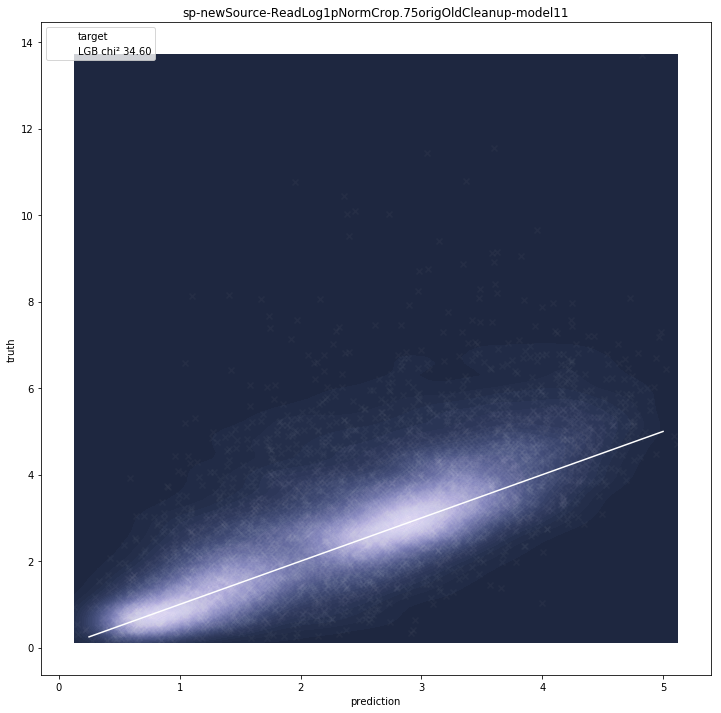

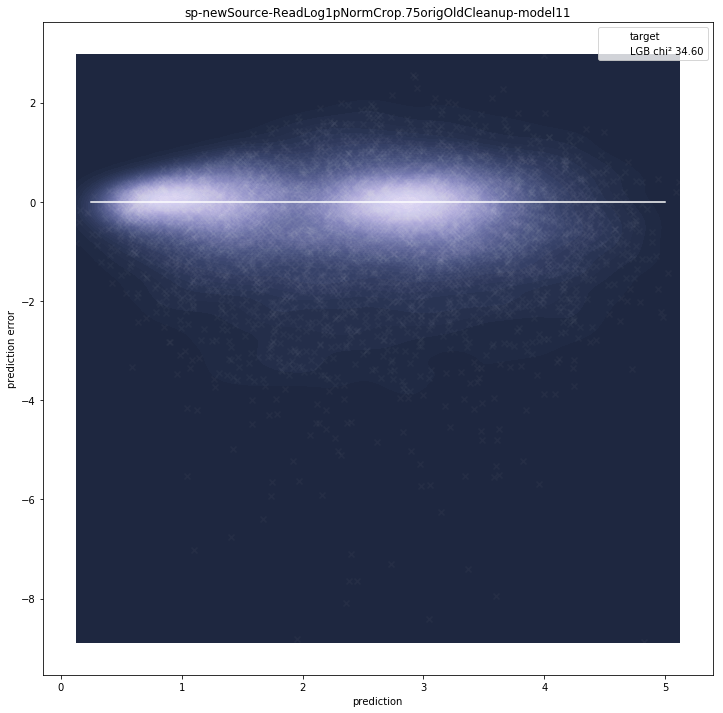

In [31]:
for i in range(len(ppreds)):
    linChiSq = xi2(ppreds[i], data[TEST+TRUTH], data[TEST+ERROR])
    print("Iteration {}: {}".format(i, linChiSq))

mpred = ppreds.reshape((10,-1)).mean(axis=0)

# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

linChiSq = xi2(mpred, data[TEST+TRUTH], data[TEST+ERROR])

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()
plt.show()

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, mpred-data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0,0], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('prediction error')

plt.legend()
plt.show()